In [1]:
import numpy as np
import math
import csv
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
COLORS=dict(zip(["burst", "utree", "centrifuge", "kraken", "bowtie2", 'burst-capitalist', 'burst-lca', 3, 4, 5], sns.color_palette("colorblind", 10)))
sns.palplot(sns.color_palette("colorblind", 10))

%matplotlib inline

In [2]:
def save_plot(fig, pltname, artists=()):
    fig.savefig(os.path.join("..", "figures", "single_strains_shogun_" + pltname + ".png"), dpi=300, bbox_extra_artists=artists, bbox_inches='tight')

def remove_plasmids(df):
    level = [_ if not "Plasmid" in _ else _.replace("Plasmid", "") for _ in df.index]
    return df.groupby(level).sum(axis=0)

In [3]:
# load up the files
bowtie2_species_files = glob.glob("../results/single_strains_shogun/**/taxatable.bowtie2.species.txt")
utree_species_files = glob.glob("../results/single_strains_shogun/**/taxatable.utree.species.txt")
burst_species_files = glob.glob("../results/single_strains_shogun/**/taxatable.burst.species.txt")
burst_taxonomy_species_files = glob.glob("../results/single_strains_shogun/**/taxatable.burst.taxonomy.species.txt")

In [4]:
# tax = pd.read_csv("../results/single_strains_shogun/ecoli_001/taxatable.burst.taxonomy.txt", sep="\t", index_col=0)
# tax_redis = pd.read_csv("../results/single_strains_shogun/ecoli_001/burst_taxatable.taxonomy.species.txt", sep="\t", index_col=0)
# cap = pd.read_csv("../results/single_strains_shogun/ecoli_001/taxatable.burst.capitalist.txt", sep="\t", index_col=0)

In [5]:
# tax

In [6]:
# tax_redis

In [7]:
# cap

In [8]:
# Get the fasta depths of each
strains = ['ecoli', 'kpneumoniae', 'saureus']
strain_depths = {}

for strain in strains:
    files = glob.glob("../results/single_strains_shogun/**/count.seqs.txt")
    for file in files:
        sequence_depth = !grep "^>" {file} | wc -l
        name = file.split('/')[-2]
#         print(name)
        strain_depths[name] =  int(sequence_depth[0])

# ecoli_depth = !wc -l ../data/single_strain/ecoli_analysis/ecoli_combined_seqs/combined_seqs_fulldepth.fna
# kpneumo_depth = !wc -l ../data/single_strain/kpneumoniae_analysis/kpneumo_combined_seqs/combined_seqs_fulldepth.fna
# saureus_depth = !wc -l ../data/single_strain/saureus_analysis/saureus_combined_seqs/combined_seqs_fulldepth.fna

In [9]:
species_tp = {}
species_tp['saureus'] = 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus_aureus'
species_tp['kpneumoniae'] = 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Klebsiella;s__Klebsiella_pneumoniae'
species_tp['ecoli'] = 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli'

columns = ["strain", "fasta_depth", "log_fasta_depth", "taxa_hits", "tp", "fp", "aligner", "hit_rate", "precision", "recall"]
rows = []
for aligner, filelist in zip(("bowtie2", "utree", "burst-capitalist", "burst-lca"), (bowtie2_species_files, utree_species_files, burst_species_files, burst_taxonomy_species_files)):
    for file in filelist:
        strain = file.split('/')[-2].split('_')[0]
        name = file.split('/')[-2]
        fasta_depth = strain_depths[name]
#         if depth == 'fulldepth':
#             fasta_depth = int(strain_depths["{strain}_fulldepth".format(strain=strain)])
#         else:
#             fasta_depth = int((10**-len(depth))*strain_depths["{strain}_fulldepth".format(strain=strain)])
#         fasta_depth = strain_depths["{strain}_{depth}".format(strain=strain, depth=depth)]l
        df_tmp = pd.read_csv(file, sep="\t", index_col=0)
        if df_tmp.shape[1] > 1:
            df_2 = pd.DataFrame(df_tmp.sum(axis=1), index=df_tmp.index)
            df_tmp = df_2
        df_tmp = remove_plasmids(df_tmp)
        taxa_hits = df_tmp.sum()[0]
        correct_hit = species_tp[strain]
        tp = df_tmp.T[correct_hit].values[0]
        fp = taxa_hits - tp
        rows.append([strain, fasta_depth, int(np.log10(fasta_depth)), taxa_hits, tp, fp, aligner, taxa_hits/fasta_depth, tp/taxa_hits, tp/fasta_depth])

In [10]:
# # coverage_files = glob.glob("../results/single_strains_shogun/**/coverage.species.txt")

# # for file in coverage_files:
# #     df = pd.read_csv(file, sep='\t', header=0, index_col=0)
# #     df['normalized_hits'] = df['hits_in_clade']*(df['unique_counts_of_clade']/df['median_genome_size'])
# #     df['relative_abundance'] = df['normalized_hits']/(df['normalized_hits'].sum())
# #     names = df[df['relative_abundance']*df['percent_of_genome_covered'] > .0001]
# #     print(names)
# #     break

# species_tp = {}
# species_tp['saureus'] = 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus_aureus'
# species_tp['kpneumoniae'] = 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Klebsiella;s__Klebsiella_pneumoniae'
# species_tp['ecoli'] = 'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia_coli'

# columns = ["strain", "fasta_depth", "log_fasta_depth", "taxa_hits", "tp", "fp", "aligner", "hit_rate", "precision", "recall"]
# rows = []
# for aligner, filelist in zip(("bowtie2", "utree", "burst-capitalist", "burst-lca"), (bowtie2_species_files, utree_species_files, burst_species_files, burst_taxonomy_species_files)):
#     for file in filelist:
#         strain = file.split('/')[-2].split('_')[0]
#         name = file.split('/')[-2]
#         fasta_depth = strain_depths[name]
# #         if depth == 'fulldepth':
# #             fasta_depth = int(strain_depths["{strain}_fulldepth".format(strain=strain)])
# #         else:
# #             fasta_depth = int((10**-len(depth))*strain_depths["{strain}_fulldepth".format(strain=strain)])
# #         fasta_depth = strain_depths["{strain}_{depth}".format(strain=strain, depth=depth)]l
#         df_tmp = pd.read_csv(file, sep="\t", index_col=0)
#         if df_tmp.shape[1] > 1:
#             df_2 = pd.DataFrame(df_tmp.sum(axis=1), index=df_tmp.index)
#             df_tmp = df_2
#         splits_file = file.split("/")
#         splits_file[-1] = "coverage.species.txt"
#         df = pd.read_csv("/".join(splits_file), sep='\t', header=0, index_col=0)
#         df['normalized_hits'] = df['hits_in_clade']
#         df['relative_abundance'] = df['normalized_hits']/(df['normalized_hits'].sum())
#         names = df[df['relative_abundance']*df['percent_of_genome_covered'] > .0001].index
#         df_tmp = df_tmp.loc[names]
# #         df_tmp = remove_plasmids(df_tmp)
#         taxa_hits = df_tmp.sum()[0]
#         correct_hit = species_tp[strain]
#         tp = df_tmp.T[correct_hit].values[0]
#         fp = taxa_hits - tp
#         rows.append([strain, fasta_depth, int(np.log10(fasta_depth)), taxa_hits, tp, fp, aligner, taxa_hits/fasta_depth, tp/taxa_hits, tp/fasta_depth])

In [11]:
df_summary = pd.DataFrame(rows, columns=columns)
# df_summary["log_fasta_depth"] = np.floor(np.log10(df_summary["fasta_depth"]))
# df_summary['log_fasta_depth']
df_summary.to_csv("../figures/single_strains_shogun_table.txt", sep="\t")
df_summary

,strain,fasta_depth,log_fasta_depth,taxa_hits,tp,fp,aligner,hit_rate,precision,recall
0,kpneumoniae,316642,5,65786,48370,17416,bowtie2,0.207761,0.735263,0.152759
1,ecoli,91,1,89,89,0,bowtie2,0.978022,1.000000,0.978022
2,kpneumoniae,3199,3,721,548,173,bowtie2,0.225383,0.760055,0.171304
3,ecoli,105,2,104,104,0,bowtie2,0.990476,1.000000,0.990476
4,saureus,265531,5,187169,177358,9811,bowtie2,0.704886,0.947582,0.667937
5,kpneumoniae,3102,3,644,482,162,bowtie2,0.207608,0.748447,0.155384
6,ecoli,9109,3,8904,8892,12,bowtie2,0.977495,0.998652,0.976177
7,kpneumoniae,315638,5,65637,48388,17249,bowtie2,0.207950,0.737206,0.153302
8,ecoli,91918,4,89910,89636,274,bowtie2,0.978154,0.996953,0.975174
9,ecoli,91859,4,89809,89451,358,bowtie2,0.977683,0.996014,0.973786


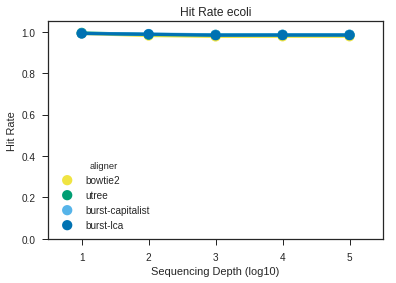

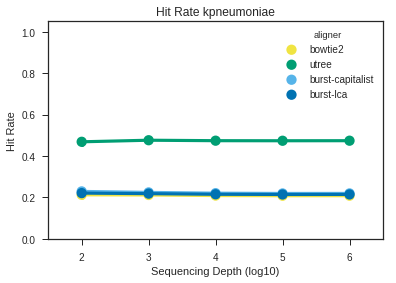

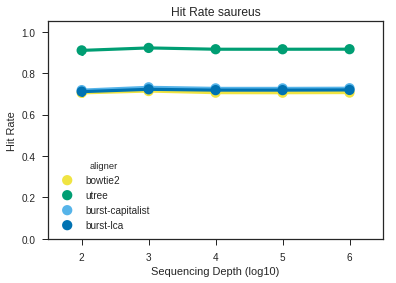

In [18]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: hit rate
# x-axis: sequencing depth

for strain in strains:
    fig, ax = plt.subplots()
    g = sns.pointplot(x="log_fasta_depth", y="hit_rate", hue="aligner", data=df_summary[df_summary['strain'] == strain], palette=COLORS, alpha=.6)

    plt.title("Hit Rate {strain}".format(strain=strain))
    plt.ylabel("Hit Rate")
    plt.xlabel("Sequencing Depth (log10)")
    g.set(xticks=np.arange(5), ylim=(0.,1.05))
    pltname = "hit_rate_{strain}".format(strain=strain)
    save_plot(fig, pltname)

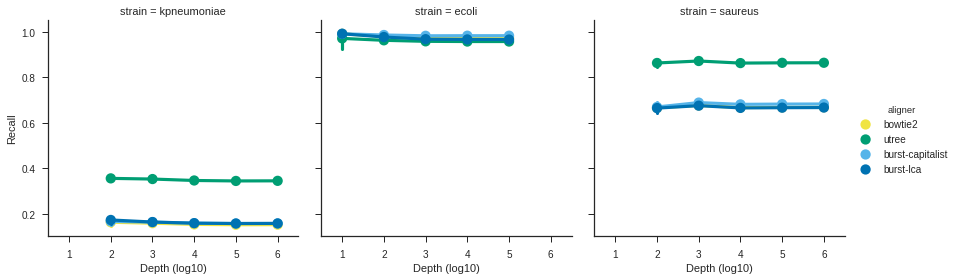

In [13]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: Recall
# x-axis: N (workers)
g = sns.factorplot(x="log_fasta_depth", y="recall", hue="aligner", col="strain", data=df_summary, palette=COLORS)
(g.set_ylabels("Recall").set_xlabels("Depth (log10)"))
pltname = "recall"
save_plot(g, pltname)

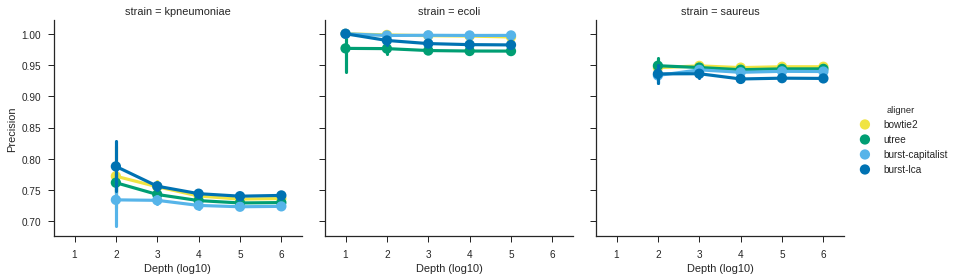

In [14]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: Precision
# x-axis: N (workers)

g = sns.factorplot(x="log_fasta_depth", y="precision", hue="aligner", col="strain", data=df_summary, sharex=True, palette=COLORS)
(g.set_ylabels("Precision").set_xlabels("Depth (log10)"))
pltname = "precision"
save_plot(g, pltname)

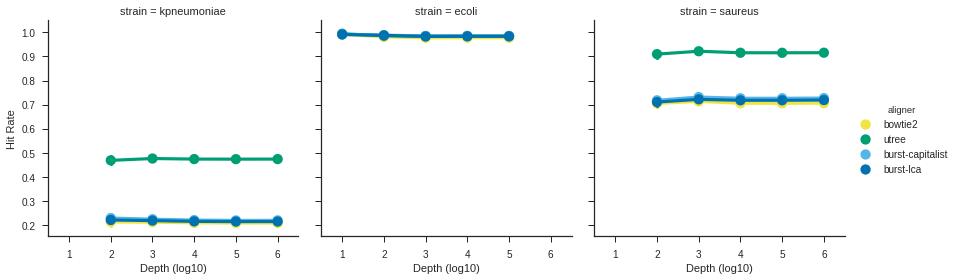

In [15]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: hit rate
# x-axis: N (workers)

g = sns.factorplot(x="log_fasta_depth", y="hit_rate", hue="aligner", col="strain", data=df_summary, sharex=True, palette=COLORS)
(g.set_ylabels("Hit Rate").set_xlabels("Depth (log10)"))
pltname = "hit_rate"
save_plot(g, pltname)

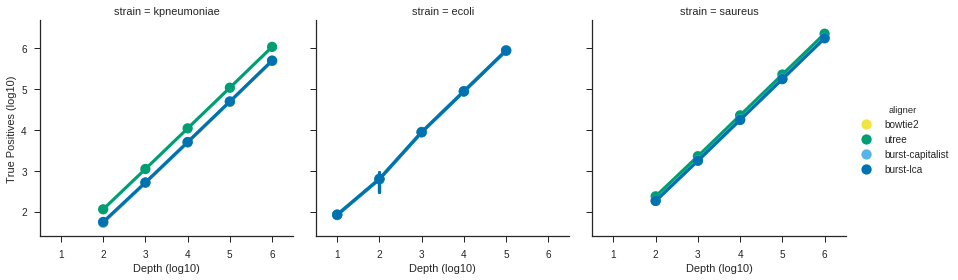

In [16]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: True Positives
# x-axis: N (workers)

df_summary['log10_tp'] = np.log10(df_summary["tp"] + 1)

g = sns.factorplot(x="log_fasta_depth", y="log10_tp", hue="aligner", col="strain", data=df_summary, sharex=True, palette=COLORS)
(g.set_ylabels("True Positives (log10)").set_xlabels("Depth (log10)"))
pltname = "log10_tp"
save_plot(g, pltname)

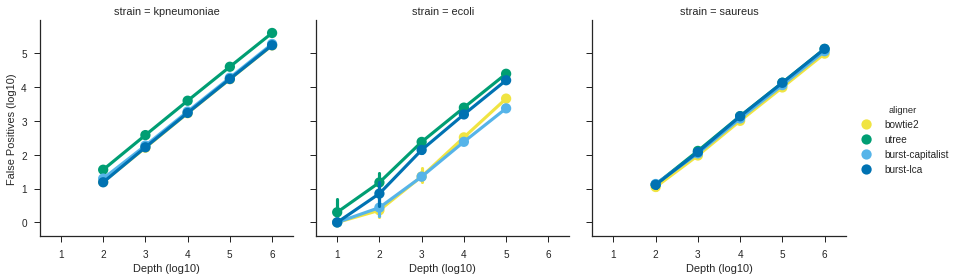

In [17]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: False Positives
# x-axis: N (workers)

df_summary['log10_fp'] = np.log10(df_summary["fp"] + 1)

g = sns.factorplot(x="log_fasta_depth", y="log10_fp", hue="aligner", col="strain", data=df_summary, sharex=True, palette=COLORS)
(g.set_ylabels("False Positives (log10)").set_xlabels("Depth (log10)"))
pltname = "log10_fp"
save_plot(g, pltname)